In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델
from statsmodels.tsa.statespace.sarimax import SARIMAX # SEASONALITY ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose # 데이터의 계절성 확인
from statsmodels.tsa.stattools import acf # 자기상관함수
from statsmodels.tsa.stattools import pacf # 편자기상관함수


from sklearn.metrics import mean_squared_error # 오차값 구하는 함수

import itertools

import warnings
warnings.filterwarnings("ignore")

import matplotlib.font_manager as fm
plt.rc('font', family='NanumBarunGothic') 

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

# ARIMA 모델링

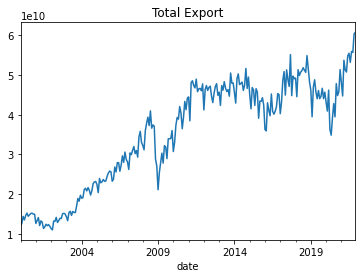

In [2]:
# 데이터 확인

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HTrain.csv' )
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df['total'].plot()
plt.title('Total Export')

plt.show()


Text(0.5, 1.0, 'Residual')

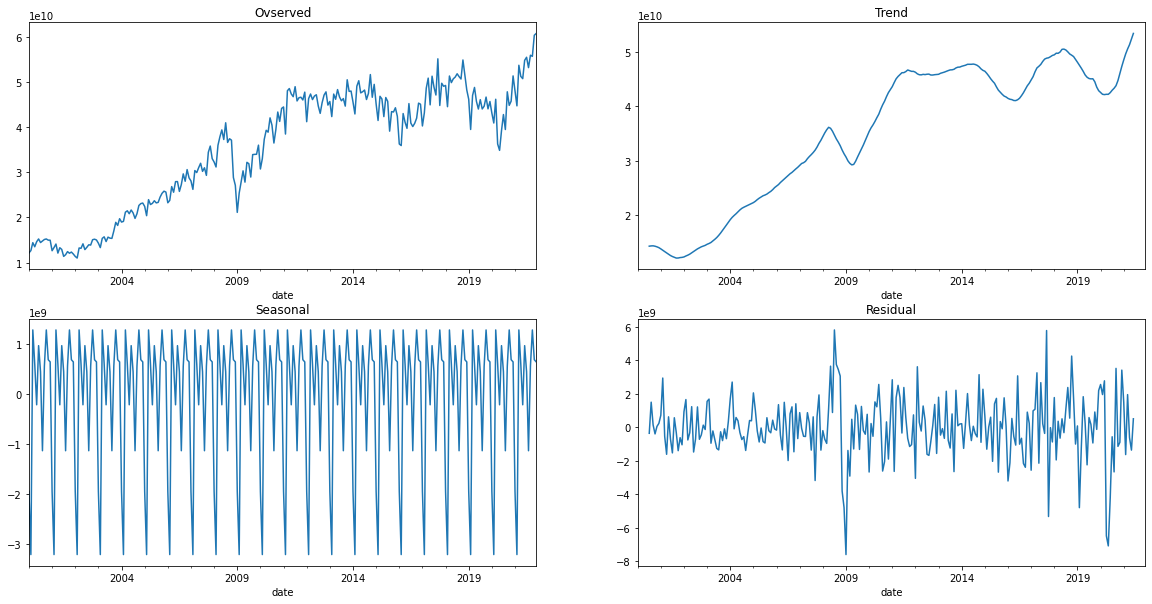

In [3]:
# raw 현황분석

total = df['total']
decomposition = seasonal_decompose(total, model='additive', freq=12)

fig, ax = plt.subplots(2,2, figsize=(20,10))

# 현황
decomposition.observed.plot(ax=ax[0][0])
ax[0][0].set_title('Ovserved')

# 추세
decomposition.trend.plot(ax=ax[0][1])
ax[0][1].set_title('Trend')

# 계절성
decomposition.seasonal.plot(ax=ax[1][0])
ax[1][0].set_title('Seasonal')

# 잔차
decomposition.resid.plot(ax=ax[1][1])
ax[1][1].set_title('Residual')


# 추세 : 우상향, 계절성 : 포함, 잔차 : 불규칙적

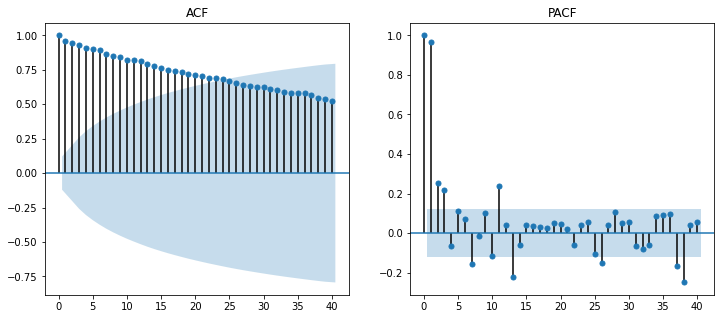

In [4]:
# 정상성 여부 파악

fig, ax = plt.subplots(1,2, figsize=(12,5))

# 자기상관함수
sm.graphics.tsa.plot_acf(total.squeeze(), lags=40, ax=ax[0])
ax[0].set_title('ACF')

# 편자기상관함수
sm.graphics.tsa.plot_pacf(total.squeeze(), lags=40, ax=ax[1])
ax[1].set_title('PACF')

plt.show()



In [5]:
# 비정상성 그래프로 판단 후 차분진행

diff_total = total.copy()
diff_total = diff_total.diff()
diff_total = diff_total.dropna()

print('차분 전 수치')
print(total)
print('-------------------------')
print('차분 후 수치')
print(diff_total)



차분 전 수치
date
2000-01-01    12162424632
2000-02-01    12676042304
2000-03-01    14429703086
2000-04-01    13522040017
2000-05-01    14636754971
                 ...     
2021-08-01    53165103786
2021-09-01    55913862375
2021-10-01    55660372637
2021-11-01    60330542263
2021-12-01    60734116670
Name: total, Length: 264, dtype: int64
-------------------------
차분 후 수치
date
2000-02-01    5.136177e+08
2000-03-01    1.753661e+09
2000-04-01   -9.076631e+08
2000-05-01    1.114715e+09
2000-06-01    6.141847e+08
                  ...     
2021-08-01   -2.296414e+09
2021-09-01    2.748759e+09
2021-10-01   -2.534897e+08
2021-11-01    4.670170e+09
2021-12-01    4.035744e+08
Name: total, Length: 263, dtype: float64


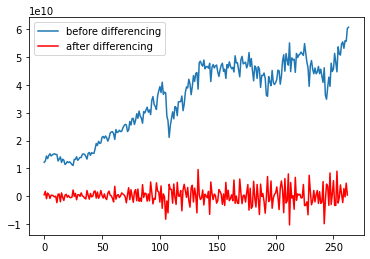

In [6]:
# 원데이터와 차분 후 데이터 비교

plt.plot(total.values, label='before differencing')
plt.plot(diff_total.values, 'r', label='after differencing')

plt.legend()
plt.show()


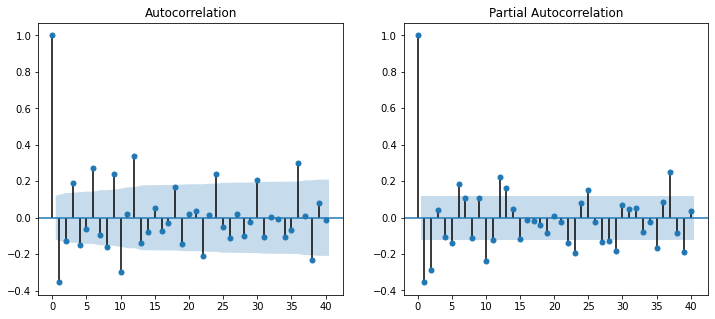

In [7]:
# 차분 후 자기상관함수와 편자기상관함수 그래프

fig, ax = plt.subplots(1,2, figsize=(12,5))

sm.graphics.tsa.plot_acf(diff_total.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_total.values.squeeze(), lags=40, ax=ax[1])
plt.show()

# 1차 차분후 정상성 데이터로 확인

In [8]:
# Graphical Method 로 찾은 임의의 order값 (1,1,1)로 모델링

model = ARIMA(total.values ,order=(1,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6087.818
Method:                       css-mle   S.D. of innovations     2731587737.220
Date:                Mon, 05 Sep 2022   AIC                          12183.637
Time:                        00:24:39   BIC                          12197.925
Sample:                             1   HQIC                         12189.379
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.847e+08    8.5e+07      2.173      0.030    1.81e+07    3.51e+08
ar.L1.D.y      0.0518      0.115      0.451      0.652      -0.173       0.277
ma.L1.D.y     -0.5240      0.095     -5.517      0.000      -0.710      -0.338
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           19.3199           +0.0000j           19.3199            0.0000
MA.1            1.9085           +0.0000j            1.9085            0.0000
-----------------------------------------------------------------------------
"""

In [9]:
##  Grid Search (AIC 낮은 모델의 order 값 찾기)

import itertools
p=range(3)
d=range(1,2)
q=range(3)
pdq = list(itertools.product(p,d,q))

aic = []

for i in pdq:
  try:
    model = ARIMA(total.values, order=(i))
    model_fit = model.fit()
    print(str(i), '=', str(round(model_fit.aic, 2)))

    aic.append(model_fit.aic)
  except:
    continue

print(min(aic))

(0, 1, 0) = 12232.6
(0, 1, 1) = 12181.84
(0, 1, 2) = 12183.52
(1, 1, 0) = 12199.36
(1, 1, 1) = 12183.64
(2, 1, 0) = 12178.53
(2, 1, 1) = 12179.85
(2, 1, 2) = 12181.54
12178.52858537056


In [10]:
# Grid Search 로 찾은 order 적용

model = ARIMA(total.values ,order=(2,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6085.264
Method:                       css-mle   S.D. of innovations     2704985822.729
Date:                Mon, 05 Sep 2022   AIC                          12178.529
Time:                        00:24:42   BIC                          12192.817
Sample:                             1   HQIC                         12184.271
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.847e+08   9.58e+07      1.928      0.054   -3.07e+06    3.72e+08
ar.L1.D.y     -0.4564      0.059     -7.737      0.000      -0.572      -0.341
ar.L2.D.y     -0.2888      0.059     -4.887      0.000      -0.405      -0.173
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7901           -1.6846j            1.8607           -0.3198
AR.2           -0.7901           +1.6846j            1.8607            0.3198
-----------------------------------------------------------------------------
"""

In [11]:
# 원데이터의 마지막 6개월 예측  (2021.07 ~ 2021.12)

pred = model_fit.forecast(6)
pred_values = pred[0]
pred_index = df.index[-6:]

pred_values

array([5.95233255e+10, 6.02817366e+10, 6.06076084e+10, 6.05621350e+10,
       6.08110910e+10, 6.10329147e+10])

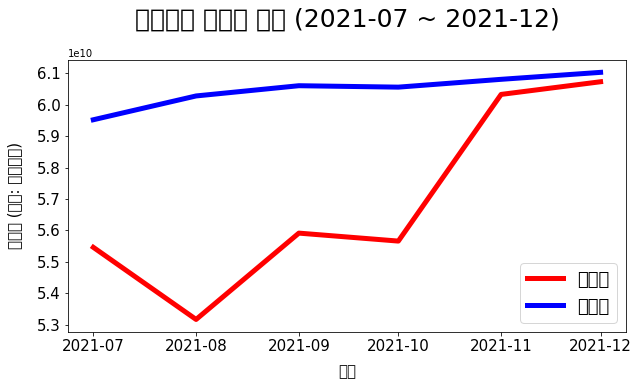




총 수출액으로만 예측한 모델의 RMSE : 4349779213
[5.95233255e+10 6.02817366e+10 6.06076084e+10 6.05621350e+10
 6.08110910e+10 6.10329147e+10]


In [12]:
real_values = df['2021-07-01':]['total']

plt.subplots(figsize=(10,5))
plt.plot(pred_index, real_values, color='red',label='실제값', linewidth=5)
plt.plot(pred_index, pred_values, color='blue', label='예측값', linewidth=5)
plt.title('실제값과 예측값 비교 (2021-07 ~ 2021-12)\n', fontsize=25)
plt.xlabel('날짜', fontsize=15, labelpad=10)
plt.xticks(fontsize=15)
plt.ylabel('예측값 (단위: 백억달러)',fontsize=15, labelpad=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=18)
plt.show()
print('\n\n')

rmse = np.sqrt(mean_squared_error(real_values, pred_values))
print('총 수출액으로만 예측한 모델의 RMSE : {}'.format(int(rmse)))
print(pred_values)

## 계절성 order 값 포함 Grid Search

In [13]:
# 계절성 ARIMA 모델사용

p = d = q = range(0, 2)
pdq = list( itertools.product(p, d, q))
seasonal_pdq = [ (x[0], x[1], x[2], 12)  for x in pdq ]


aic = 10000000
temp_order = 0
temp_sorder = 0

for ord in pdq:
  for seasonal_ord in seasonal_pdq:
    try:
      model = sm.tsa.statespace.SARIMAX(total.values,
                                        order = ord,
                                        seasonal_order = seasonal_ord)
      
      result = model.fit()

      if result.aic < aic:
        aic = result.aic
        temp_order = ord
        temp_sorder = seasonal_ord


    except:
      continue

print('Order : {}, Seasonal_Order : {}'.format(temp_order, temp_sorder))

Order : (1, 1, 0), Seasonal_Order : (0, 1, 1, 12)


In [14]:
# Grid Search 로 찾은 order, seasonal_order 로 모델링

model = SARIMAX(total.values ,order=(1,1,0), seasonal_order=(0,1,1,12))
model_fit = model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  264
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -5795.695
Date:                              Mon, 05 Sep 2022   AIC                          11597.390
Time:                                      00:24:57   BIC                          11607.966
Sample:                                           0   HQIC                         11601.646
                                              - 264                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4070      0.079     -5.121      0.000      -0.563      -0.251
ma.S.L12      -0.7660      0.073    -10.451      0.000      -0.910      -0.622
sigma2      9.555e+18   2.57e-21   3.72e+39      0.000    9.56e+18    9.56e+18
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                87.08
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               4.98   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.54e+54. Standard errors may be unstable.
"""

In [18]:
# 원데이터의 마지막 6개월 예측  (2021.07 ~ 2021.12)
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.3f}".format(x)})
pred = model_fit.get_forecast(6)
pred_values = pred.predicted_mean
pred_index = df.index[-6:]

pred_values

array([58194773044.108, 55418466069.665, 62101455806.272, 59894835782.153,
       58412215820.450, 61032986792.474])

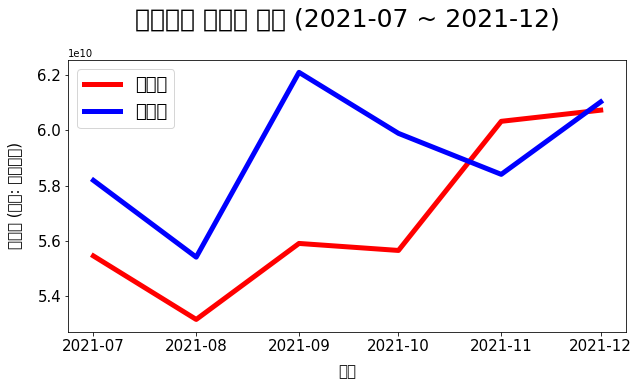







계절성 모델의 RMSE : 3476938647
[5.81947730e+10 5.54184661e+10 6.21014558e+10 5.98948358e+10
 5.84122158e+10 6.10329868e+10]


In [17]:
plt.subplots(figsize=(10,5))
plt.plot(pred_index, real_values, color='red',label='실제값', linewidth=5)
plt.plot(pred_index, pred_values, color='blue', label='예측값', linewidth=5)
plt.title('실제값과 예측값 비교 (2021-07 ~ 2021-12)\n', fontsize=25)
plt.xlabel('날짜', fontsize=15, labelpad=10)
plt.xticks(fontsize=15)
plt.ylabel('예측값 (단위: 백억달러)',fontsize=15, labelpad=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=18)
plt.show()
print('\n\n\n\n\n')

rmse_seasonal = np.sqrt(mean_squared_error(real_values, pred_values))
print('계절성 모델의 RMSE : {}'.format(int(rmse_seasonal)))
print(pred_values)
# 계절성 적용한 모델이 오차가 더 적음

## 5개국 (중국, 미국, 베트남, 홍콩, 일본) 포함 예측

In [19]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HTrain.csv')
df = df.set_index('date')

df_pred = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HTest.csv')
df_pred = df_pred.set_index('date')

# 총 수출액
total = df['total']

# 최종 csv 파일에는 기타 변수가 모두 포함되어 있으므로 5개국 이외의 변수 drop

# 5개국 수출액
exog = df.drop(['total','ex_rate', 'oecd_index','korea_index','oil'], axis=1) 


print('----------------------total---------------------')
print(total)
print('----------------------exog1---------------------')
print(exog)


----------------------total---------------------
date
2000-01-01    12162424632
2000-02-01    12676042304
2000-03-01    14429703086
2000-04-01    13522040017
2000-05-01    14636754971
                 ...     
2021-08-01    53165103786
2021-09-01    55913862375
2021-10-01    55660372637
2021-11-01    60330542263
2021-12-01    60734116670
Name: total, Length: 264, dtype: int64
----------------------exog1---------------------
                  china         usa     vietnam    hongkong       japan
date                                                                   
2000-01-01   1235215271  2609787984   109742698   782348732  1551722070
2000-02-01   1273117309  2554309883   112395157   823990122  1518844843
2000-03-01   1437377223  2946820669   150134562   911648256  1783564618
2000-04-01   1366876604  2698029849   169146208   863243219  1582707525
2000-05-01   1663240667  3167181403   169411680   887081090  1671039709
...                 ...         ...         ...         ...         

# 함수 정의(2021.7 - 2021.12 까지 예측)
-Gird Search 포함 (변수 : 5개국)


In [20]:
p = d = q = range(0, 2)
pdq = list( itertools.product(p, d, q))

seasonal_pdq = [ (x[0], x[1], x[2], 12)  for x in pdq ]


# 총 수출액, 변수, 모델링에서 제외시킬 나라 (또는 변수) 를 받는 예측함수 정의

def predict1(total, exog, not_used_country):
  global rmse, real_values, pred_values
  aic = 10000000
  temp_order = 0
  temp_sorder = 0

  if not_used_country == None:
    pass
  else:
    exog = exog.drop(not_used_country, axis=1)

  for ord in pdq:
    for seasonal_ord in seasonal_pdq:
      try:
        model = sm.tsa.statespace.SARIMAX(total.values,
                                          order = ord,
                                          seasonal_order = seasonal_ord)
        
        result = model.fit()


        if result.aic < aic:
          aic = result.aic
          temp_order = ord
          temp_sorder = seasonal_ord


      except:
        continue

  print(temp_order, temp_sorder, aic)

  model = SARIMAX(total.values[:-6],
                  exog=exog[:-6],
                  order=temp_order,
                  seasonal_order=temp_sorder)
  
  model = model.fit()

  pred = model.get_forecast(6, exog=exog[-6:])
  pred_values = pred.predicted_mean
  
  real_values = total.values[-6:]

  rmse = np.sqrt(mean_squared_error(real_values, pred_values))

  print('RMSE : {}'.format(int(rmse)))
  

In [21]:
# 모든 나라를 포함시키기 때문에 3번째 값은 None (제외할 나라 없음)
predict1(total, exog, None)

(1, 1, 0) (0, 1, 1, 12) 11597.389605807868
RMSE : 1252287914


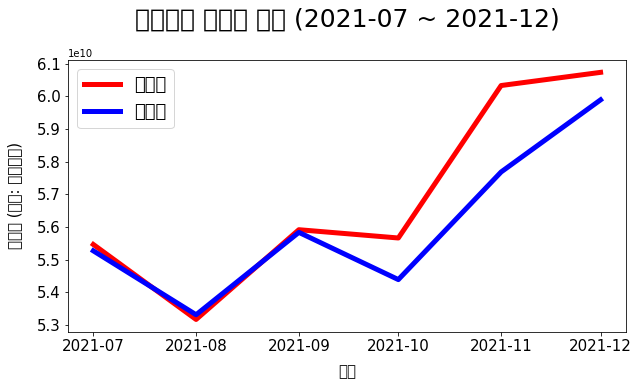







5개국의 수출액을 변수로 사용한 모델의 RMSE : 1252287914.700322
2021-07-01   55267078573.26469
2021-08-01   53308808258.37357
2021-09-01   55832456089.73473
2021-10-01   54386171123.98042
2021-11-01   57682467813.63410
2021-12-01   59892464941.84921
Freq: MS, Name: predicted_mean, dtype: float64


In [22]:
plt.subplots(figsize=(10,5))
plt.plot(pred_index, real_values, color='red',label='실제값', linewidth=5)
plt.plot(pred_index, pred_values, color='blue', label='예측값', linewidth=5)
plt.title('실제값과 예측값 비교 (2021-07 ~ 2021-12)\n', fontsize=25)
plt.xlabel('날짜', fontsize=15, labelpad=10)
plt.xticks(fontsize=15)
plt.ylabel('예측값 (단위: 백억달러)',fontsize=15, labelpad=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=18)
plt.show()
print('\n\n\n\n\n')

print('5개국의 수출액을 변수로 사용한 모델의 RMSE : {}'.format(rmse))
print(pred_values)

In [23]:
# Grid Search 로 찾은 3개의 order, seasonal_order 조합중 RMSE가 가장 낮았던 (1,1,0) (1,1,1,12) 사용

def predict2(total, exog, not_used_cols):
  global rmse, real_values, pred_values
  if not_used_cols == None:
    pass
  else:
    exog = exog.drop(not_used_cols, axis=1)

  
  model = SARIMAX(total[:-6],
                  exog=exog[:-6],
                  order=(1,1,0),
                  seasonal_order=(1,1,1,12))
  
  model = model.fit()

  pred = model.get_forecast(6, exog=exog[-6:])
  pred_values = pred.predicted_mean

  real_values = total.values[-6:]
  
  rmse = np.sqrt(mean_squared_error(real_values, pred_values))

  print('RMSE : {}'.format(int(rmse)))

In [24]:
predict2(total, exog, None)

RMSE : 1068324014


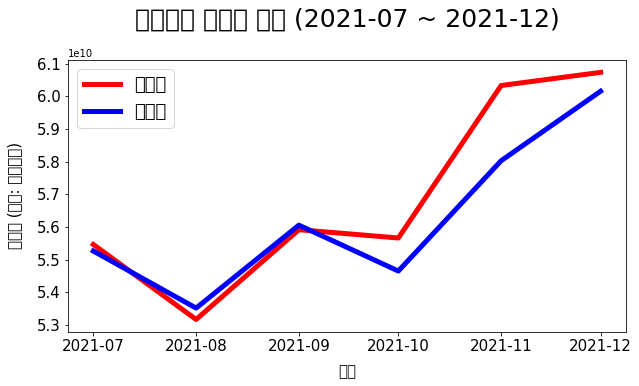







선정한 3개의 order값중 가장 오차가 적은 모델의 RMSE : 1068324014.0189313


In [25]:
plt.subplots(figsize=(10,5))
plt.plot(pred_index, real_values, color='red',label='실제값', linewidth=5)
plt.plot(pred_index, pred_values, color='blue', label='예측값', linewidth=5)
plt.title('실제값과 예측값 비교 (2021-07 ~ 2021-12)\n', fontsize=25)
plt.xlabel('날짜', fontsize=15, labelpad=10)
plt.xticks(fontsize=15)
plt.ylabel('예측값 (단위: 백억달러)',fontsize=15, labelpad=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=18)
plt.show()
print('\n\n\n\n\n')

print('선정한 3개의 order값중 가장 오차가 적은 모델의 RMSE : {}'.format(rmse))

## 기타 변수 포함 (환율, 유가, 한국 경기선행지수, OECD 경기선행지수)
### 변수 : 5개국 + 기타 변수

In [26]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HTrain.csv')
df = df.set_index('date')

# 총 수출액
total = df['total']


# 5개국 수출액과 기타 변수
exog = df.drop(['total'], axis=1)

print('----------------------total---------------------')
print(total)
print('----------------------exog1---------------------')
print(exog)


----------------------total---------------------
date
2000-01-01    12162424632
2000-02-01    12676042304
2000-03-01    14429703086
2000-04-01    13522040017
2000-05-01    14636754971
                 ...     
2021-08-01    53165103786
2021-09-01    55913862375
2021-10-01    55660372637
2021-11-01    60330542263
2021-12-01    60734116670
Name: total, Length: 264, dtype: int64
----------------------exog1---------------------
                  china         usa     vietnam    hongkong       japan  \
date                                                                      
2000-01-01   1235215271  2609787984   109742698   782348732  1551722070   
2000-02-01   1273117309  2554309883   112395157   823990122  1518844843   
2000-03-01   1437377223  2946820669   150134562   911648256  1783564618   
2000-04-01   1366876604  2698029849   169146208   863243219  1582707525   
2000-05-01   1663240667  3167181403   169411680   887081090  1671039709   
...                 ...         ...         ...

## - RMSE 가 가장 낮았던 유가와 한국 경기선행지수만 변수로 사용
### 변수 : 5개국, 유가, 경기선행지수(한국)

In [27]:
def predict3(total, exog, not_used_cols):
  global rmse, real_values, pred_values
  if not_used_cols == None:
    pass
  else:
    exog = exog.drop(not_used_cols, axis=1)

  # Grid Search 로 찾은 3개의 order, seasonal_order 조합중 가장 RMSE 가 낮았던 값 사용
  model = SARIMAX(total[0:-6],
                  exog=exog[0:-6],
                  order=(1,1,0),
                  seasonal_order=(1,1,1,12))
  
  model = model.fit()

  pred = model.get_forecast(6, exog=exog[-6:])
  pred_values = pred.predicted_mean

  real_values = total.values[-6:]
  
  rmse = np.sqrt(mean_squared_error(real_values, pred_values))

  print('RMSE : {}'.format(int(rmse)))

In [28]:
# 사용하지 않을 경기선행지수(OECD) 와 환율 제외
predict3(total, exog, ['oecd_index', 'ex_rate'])

RMSE : 996403051


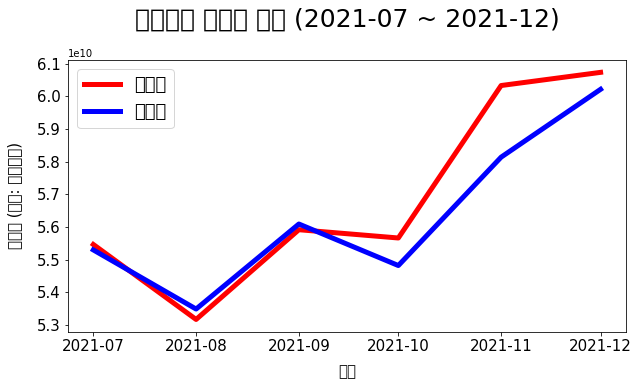







5개국및 기타변수 2개 사용한 모델의 RMSE : 996403051.5765626
2021-07-01   55295134656.96326
2021-08-01   53484085220.02318
2021-09-01   56088362395.25375
2021-10-01   54816369622.55042
2021-11-01   58136198415.82671
2021-12-01   60214939092.43217
Freq: MS, Name: predicted_mean, dtype: float64


In [29]:
# 5개국 및 기타 변수 포함
plt.subplots(figsize=(10,5))
plt.plot(pred_index, real_values, color='red',label='실제값', linewidth=5)
plt.plot(pred_index, pred_values, color='blue', label='예측값', linewidth=5)
plt.title('실제값과 예측값 비교 (2021-07 ~ 2021-12)\n', fontsize=25)
plt.xlabel('날짜', fontsize=15, labelpad=10)
plt.xticks(fontsize=15)
plt.ylabel('예측값 (단위: 백억달러)',fontsize=15, labelpad=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=18)
plt.show()
print('\n\n\n\n\n')

print('5개국및 기타변수 2개 사용한 모델의 RMSE : {}'.format(rmse))
print(pred_values)

## 과거 관측값 사용기간 조정
### RMSE 가 가장 낮았던 2006.01 - 2021.12 기간만 사용

In [30]:
data = exog.drop(['oecd_index', 'ex_rate'], axis=1)

for i in range(0,205,12):
  date_from = df.index[i]
  date_to = '2021-06-01'

  model = SARIMAX(total[date_from:date_to], exog=data[date_from:date_to], order=(1,1,0), seasonal_order=(1,1,1,12))
  model = model.fit()

  pred = model.get_forecast(6, exog=data[-6:])
  pred_values = pred.predicted_mean

  real_values = total.values[-6:]
  
  rmse = np.sqrt(mean_squared_error(real_values, pred_values))

  print('{}부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : {}'.format(date_from, rmse))

2000-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 996403051.5765626
2001-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 979799094.1718745
2002-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 941015937.39154
2003-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 797178641.7894225
2004-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 872594609.5836903
2005-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 870264942.4314625
2006-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 932566300.9042832
2007-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 797022830.5978773
2008-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1295034495.056134
2009-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1581200392.3332129
2010-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1267796503.2116878
2011-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1405300433.4729073
2012-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1312535417.6216555
2013-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1388518656.7313766
2014-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1667330135.2301729
2015-01-01부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 1509217479.1482496
2016-01-01부터의 데이터를 

In [31]:
def predict4(total, exog, not_used_cols):
  global rmse, real_values, pred_values
  if not_used_cols == None:
    pass
  else:
    exog = exog.drop(not_used_cols, axis=1)

# 과거 관측값 사용기간 2007년 1월 ~ 2021년 6월
  model = SARIMAX(total[84:-6],
                  exog=exog[84:-6],
                  order=(1,1,0),
                  seasonal_order=(1,1,1,12))
  
  model = model.fit()

  pred = model.get_forecast(6, exog=exog[-6:])
  pred_values = pred.predicted_mean

  real_values = total.values[-6:]
  
  rmse = np.sqrt(mean_squared_error(real_values, pred_values))

  print('RMSE : {}'.format(int(rmse)))

In [32]:
predict4(total, exog, ['ex_rate','oecd_index'])
print(pred_values)

RMSE : 797022830
2021-07-01   55268807849.78554
2021-08-01   53636350198.32314
2021-09-01   56231203249.26482
2021-10-01   55151857180.38673
2021-11-01   58545756088.81531
2021-12-01   60647473592.34252
Freq: MS, Name: predicted_mean, dtype: float64


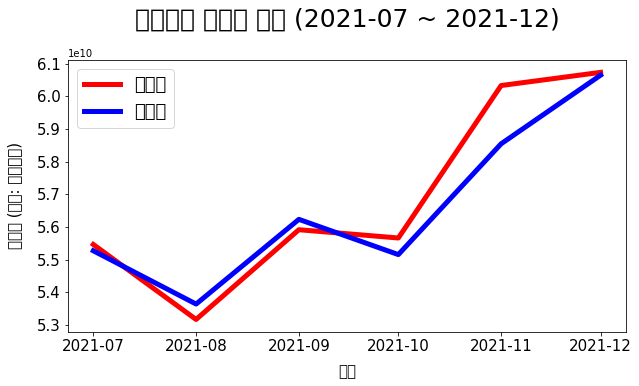







2007년도 부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : 797022830.5978773
2021-07-01   55268807849.78554
2021-08-01   53636350198.32314
2021-09-01   56231203249.26482
2021-10-01   55151857180.38673
2021-11-01   58545756088.81531
2021-12-01   60647473592.34252
Freq: MS, Name: predicted_mean, dtype: float64


In [34]:
# 5개국 및 기타 변수 포함
plt.subplots(figsize=(10,5))
plt.plot(pred_index, real_values, color='red',label='실제값', linewidth=5)
plt.plot(pred_index, pred_values, color='blue', label='예측값', linewidth=5)
plt.title('실제값과 예측값 비교 (2021-07 ~ 2021-12)\n', fontsize=25)
plt.xlabel('날짜', fontsize=15, labelpad=10)
plt.xticks(fontsize=15)
plt.ylabel('예측값 (단위: 백억달러)',fontsize=15, labelpad=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=18)
plt.show()
print('\n\n\n\n\n')

print('2007년도 부터의 데이터를 과거 관측값으로 사용한 모델의 RMSE : {}'.format(rmse))
print(pred_values)

# 최종 예측 (2022.01 - 2022.06) 


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HTrain.csv')
df = df.set_index('date')

### 각 나라별 수출액 및 변수 예측 (2022.01 - 2022.06)

In [ ]:
# 예측할 변수를 받는 함수 정의

def predict_exog(used_col):

  model = sm.tsa.statespace.SARIMAX(
    df[used_col],
    order = (1, 1, 0),
    seasonal_order = (1, 1, 1, 12),
    # AR 매개 변수를 변환하여 모델의 자동 회귀 구성 요소에서 정상 성을 강제 적용할지 여부
    enforce_stationarity = False,

    # 모델의 이동 평균 구성 요소에서 반전 성을 강제하기 위해 MA 매개 변수를 변환할지 여부
    enforce_invertibility = False)
  results = model.fit()

  forecast = results.get_forecast( steps = 6)

  pred_values = round(forecast.predicted_mean, 2)

  return pred_values

In [ ]:
china = predict_exog('china')
usa = predict_exog('usa')
vietnam = predict_exog('vietnam')
hongkong = predict_exog('hongkong')
japan = predict_exog('japan')
korea_index = predict_exog('korea_index')
oil = predict_exog('oil')

In [ ]:
# 예측한 값 데이터 프레임으로 저장

pred_arr = np.array((china, usa, vietnam, hongkong, japan, korea_index, oil))

cols = ['china', 'usa', 'vietnam', 'hongkong', 'japan', 'korea index', 'oil']

predicted_exog = pd.DataFrame(index=china.index, columns=cols)
predicted_exog.index.names = ['date']

for i in range(6):
  for q in range(7):
    predicted_exog.iloc[i][q] = pred_arr[q][i]

# 만든 데이터 프레임 csv파일로 저장
predicted_exog.to_csv('predicted_exog.csv')

### 위에서 예측한 변수로 최종 예측

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HTrain.csv')
df = df.set_index('date')

total = df['total']
exog = df.drop('total', axis=1)


# 위에서 만든 csv 파일 불러오기
predicted_exog = pd.read_csv('/content/predicted_exog.csv')
predicted_exog = predicted_exog.set_index('date')

print('------------------------총 수출액---------------------')
print(total)
print('-------------------------변수------------------------ ')
print(exog)
print('-------------------------예측한 변수---------------------')
print(predicted_exog)

------------------------총 수출액---------------------
date
2000-01-01    12162424632
2000-02-01    12676042304
2000-03-01    14429703086
2000-04-01    13522040017
2000-05-01    14636754971
                 ...     
2021-08-01    53165103786
2021-09-01    55913862375
2021-10-01    55660372637
2021-11-01    60330542263
2021-12-01    60734116670
Name: total, Length: 264, dtype: int64
-------------------------변수------------------------ 
                  china         usa     vietnam    hongkong       japan  \
date                                                                      
2000-01-01   1235215271  2609787984   109742698   782348732  1551722070   
2000-02-01   1273117309  2554309883   112395157   823990122  1518844843   
2000-03-01   1437377223  2946820669   150134562   911648256  1783564618   
2000-04-01   1366876604  2698029849   169146208   863243219  1582707525   
2000-05-01   1663240667  3167181403   169411680   887081090  1671039709   
...                 ...         ...      

In [ ]:
def predict_final(total, exog, predicted_exog, not_used_cols):
  global pred_values
  if not_used_cols == None:
    pass
  else:
    exog = exog.drop(not_used_cols, axis=1)

  
  model = SARIMAX(total[84:],
                  exog=exog[84:],
                  order=(1,1,0),
                  seasonal_order=(1,1,1,12))
  
  model = model.fit()

  pred = model.get_forecast(6, exog=predicted_exog)
  pred_values = pred.predicted_mean
  print('-----예측한 값------')
  print('')
  print('')
  return pred_values

In [ ]:
pd.options.display.float_format = '{:.5f}'.format
predict_final(total, exog, predicted_exog, ['oecd_index','ex_rate'])



-----예측한 값------




2022-01-01   58111201539.49973
2022-02-01   55853527036.65961
2022-03-01   62938985897.95298
2022-04-01   60268974973.31096
2022-05-01   59209221111.50418
2022-06-01   61601237273.49693
Freq: MS, Name: predicted_mean, dtype: float64

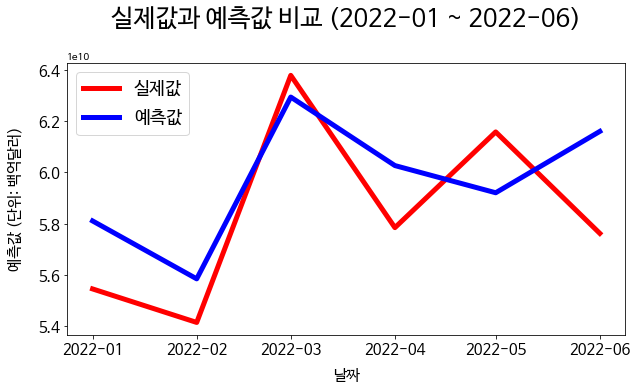







2022-01-01   58111201539.49973
2022-02-01   55853527036.65961
2022-03-01   62938985897.95298
2022-04-01   60268974973.31096
2022-05-01   59209221111.50418
2022-06-01   61601237273.49693
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:

real_values = np.array([55460865000, 54154313000, 63785078000, 57849157000, 61579891000, 57625856000])

plt.subplots(figsize=(10,5))
plt.plot(pred_values.index, real_values, color='red',label='실제값', linewidth=5)
plt.plot(pred_values.index, pred_values, color='blue', label='예측값', linewidth=5)
plt.title('실제값과 예측값 비교 (2022-01 ~ 2022-06)\n', fontsize=25)
plt.xlabel('날짜', fontsize=15, labelpad=10)
plt.xticks(fontsize=15)
plt.ylabel('예측값 (단위: 백억달러)',fontsize=15, labelpad=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=18)
plt.show()
print('\n\n\n\n\n')
print(pred_values)